In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("combined_filtered.csv") 
df 

,Unnamed: 0,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,1,2023-09-19T14:21:53.485Z,1,0,0,1862,11896,1679,2396,2643,11908,0,1
2,2,2023-09-19T14:21:53.582Z,1,0,0,1867,11957,1669,2379,2659,11939,0,1
3,3,2023-09-19T14:21:53.687Z,1,0,0,1886,11955,1699,2403,2612,11932,0,1
4,4,2023-09-19T14:21:53.793Z,1,0,0,1887,11966,1670,2388,2630,11931,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216029,216029,2023-09-19T20:21:59.584Z,0,0,0,1888,2061,1676,2382,2604,11801,1,0
216030,216030,2023-09-19T20:21:59.686Z,0,0,0,1854,2061,1686,2404,2776,11878,1,0
216031,216031,2023-09-19T20:21:59.785Z,0,0,0,1859,2073,1685,2403,3218,11917,1,0
216032,216032,2023-09-19T20:21:59.887Z,0,0,0,1860,2067,1655,2385,2176,11904,1,0


In [3]:
df['Anomally'] = df['Anomally'].replace({'N': 0, 'Y': 1})
df
df=df.rename(columns={"Success?": "Success"})

df['Success'] = df['Success'].replace({'N': 0, 'Y': 1})
df

,Unnamed: 0,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,1,2023-09-19T14:21:53.485Z,1,0,0,1862,11896,1679,2396,2643,11908,0,1
2,2,2023-09-19T14:21:53.582Z,1,0,0,1867,11957,1669,2379,2659,11939,0,1
3,3,2023-09-19T14:21:53.687Z,1,0,0,1886,11955,1699,2403,2612,11932,0,1
4,4,2023-09-19T14:21:53.793Z,1,0,0,1887,11966,1670,2388,2630,11931,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216029,216029,2023-09-19T20:21:59.584Z,0,0,0,1888,2061,1676,2382,2604,11801,1,0
216030,216030,2023-09-19T20:21:59.686Z,0,0,0,1854,2061,1686,2404,2776,11878,1,0
216031,216031,2023-09-19T20:21:59.785Z,0,0,0,1859,2073,1685,2403,3218,11917,1,0
216032,216032,2023-09-19T20:21:59.887Z,0,0,0,1860,2067,1655,2385,2176,11904,1,0


### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 1 minute apart. We will shift the labels in column `y` by 70 rows to do a 1 minute ahead prediction.

In [4]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['Success'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'Success'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['Success'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -70)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,Unnamed: 0,_time,GreenRocket,Door1,Door2


After shifting


,Success,Unnamed: 0,_time,GreenRocket,Door1


In [6]:
# Remove time column, and the categorical columns
df = df.drop(['_time', 'Unnamed: 0'], axis=1)

In [7]:
df

,Success,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally
59019,0.0,0,1,0,1877,12035,1697,2388,2522,12053,1
59020,0.0,0,1,0,1914,12125,1697,2388,2651,12150,1
59021,0.0,0,1,0,1898,12073,1690,2392,2460,12003,1
59022,0.0,0,1,0,1887,12084,1710,2387,2493,12082,1
59023,0.0,0,1,0,1889,12054,1694,2380,2526,12108,1
...,...,...,...,...,...,...,...,...,...,...,...
216029,0.0,0,0,0,1888,2061,1676,2382,2604,11801,1
216030,0.0,0,0,0,1854,2061,1686,2404,2776,11878,1
216031,0.0,0,0,0,1859,2073,1685,2403,3218,11917,1
216032,0.0,0,0,0,1860,2067,1655,2385,2176,11904,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3738 entries, 59019 to 216033
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Success            3738 non-null   float64
 1   GreenRocket        3738 non-null   int64  
 2   Door1              3738 non-null   int64  
 3   Door2              3738 non-null   int64  
 4   LoadCell_R02       3738 non-null   int64  
 5   Potentiometer_R02  3738 non-null   int64  
 6   LoadCell_R03       3738 non-null   int64  
 7   Potentiometer_R03  3738 non-null   int64  
 8   LoadCell_R04       3738 non-null   int64  
 9   Potentiometer_R04  3738 non-null   int64  
 10  Anomally           3738 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 350.4 KB


In [9]:
input_X = df.loc[:, df.columns != 'Success'].values  # converts the df to a numpy array
input_y = df['Success'].values

n_features = input_X.shape[1]  # number of features

In [10]:
n_features

10

In [11]:
input_y

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
input_X

array([[    0,     1,     0, ...,  2522, 12053,     1],
       [    0,     1,     0, ...,  2651, 12150,     1],
       [    0,     1,     0, ...,  2460, 12003,     1],
       ...,
       [    0,     0,     0, ...,  3218, 11917,     1],
       [    0,     0,     0, ...,  2176, 11904,     1],
       [    0,     0,     0, ...,  3437, 11906,     1]])

In [13]:
n_features

10

In [14]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [15]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 70  # Equivalent to 1 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,Success,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally
60699,0.0,1,0,0,1857,11885,1695,2400,2654,11838,1
60700,0.0,1,0,0,1868,11939,1695,2392,2661,11905,1
60701,0.0,1,0,0,1876,11899,1682,2403,2586,11790,1
60702,0.0,1,0,0,1861,11896,1682,2384,2680,11847,1
60703,0.0,1,0,0,1859,11974,1693,2403,2707,11931,1
60704,1.0,1,0,0,1870,11890,1691,2403,2924,12086,1


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9
0,1,0,0,1893,11955,1695,2391,2631,11905,1
1,1,0,0,1870,11952,1696,2392,2645,11867,1
2,1,0,0,1857,11914,1705,2403,2685,11891,1
3,1,0,0,1855,11946,1673,2385,2568,11837,1
4,1,0,0,1865,11978,1688,2393,2580,11883,1
...,...,...,...,...,...,...,...,...,...,...
65,1,0,0,1868,11939,1695,2392,2661,11905,1
66,1,0,0,1876,11899,1682,2403,2586,11790,1
67,1,0,0,1861,11896,1682,2384,2680,11847,1
68,1,0,0,1859,11974,1693,2403,2707,11931,1


The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to predict y(t).

In [16]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


In [17]:
X_train.shape

(2346, 70, 1, 10)

In [18]:
np.array(y)

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [20]:
X_train_y0.shape

(2209, 70, 1, 10)

In [21]:
X_valid_y0.shape

(555, 70, 1, 10)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [22]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [23]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [24]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [25]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [26]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0.359891 -0.437302  0.        0.019919 -0.373472  0.        0.25034
 -0.026256  0.030783  0.      ]
colwise variance [0.23036957 0.24606895 0.         0.48126916 0.35983951 0.46265278
 0.18766964 0.63308155 0.4952045  0.        ]


The test succeeded. Now we will _scale_ the validation and test sets.

In [27]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

In [46]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 200
batch = 64
lr = 0.0001

In [47]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 70, 32)            5504      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 70, 16)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 70, 16)            2112      
                                                                 
 lstm_7 (LSTM)               (None, 70, 32)            6272      
                                                                 
 time_distributed_1 (TimeDis  (None, 70, 10)           330       
 tributed)                                            

In [48]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier_mcnair.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/200
35/35 - 5s - loss: 0.3495 - val_loss: 0.3447 - 5s/epoch - 131ms/step
Epoch 2/200
35/35 - 2s - loss: 0.3374 - val_loss: 0.3258 - 2s/epoch - 65ms/step
Epoch 3/200
35/35 - 2s - loss: 0.3474 - val_loss: 0.3168 - 2s/epoch - 65ms/step
Epoch 4/200
35/35 - 2s - loss: 0.3112 - val_loss: 0.3037 - 2s/epoch - 66ms/step
Epoch 5/200
35/35 - 2s - loss: 0.2980 - val_loss: 0.2928 - 2s/epoch - 68ms/step
Epoch 6/200
35/35 - 2s - loss: 0.2887 - val_loss: 0.2850 - 2s/epoch - 70ms/step
Epoch 7/200
35/35 - 2s - loss: 0.2811 - val_loss: 0.2782 - 2s/epoch - 67ms/step
Epoch 8/200
35/35 - 2s - loss: 0.2743 - val_loss: 0.2719 - 2s/epoch - 69ms/step
Epoch 9/200
35/35 - 2s - loss: 0.2684 - val_loss: 0.2670 - 2s/epoch - 66ms/step
Epoch 10/200
35/35 - 2s - loss: 0.2638 - val_loss: 0.2632 - 2s/epoch - 67ms/step
Epoch 11/200
35/35 - 2s - loss: 0.2602 - val_loss: 0.2596 - 2s/epoch - 66ms/step
Epoch 12/200
35/35 - 2s - loss: 0.2569 - val_loss: 0.2565 - 2s/epoch - 66ms/step
Epoch 13/200
35/35 - 2s - loss: 0.25

Epoch 103/200
35/35 - 2s - loss: 0.1920 - val_loss: 0.1914 - 2s/epoch - 65ms/step
Epoch 104/200
35/35 - 2s - loss: 0.1919 - val_loss: 0.1913 - 2s/epoch - 65ms/step
Epoch 105/200
35/35 - 2s - loss: 0.1918 - val_loss: 0.1911 - 2s/epoch - 65ms/step
Epoch 106/200
35/35 - 2s - loss: 0.1916 - val_loss: 0.1910 - 2s/epoch - 65ms/step
Epoch 107/200
35/35 - 2s - loss: 0.1915 - val_loss: 0.1909 - 2s/epoch - 68ms/step
Epoch 108/200
35/35 - 3s - loss: 0.1914 - val_loss: 0.1907 - 3s/epoch - 78ms/step
Epoch 109/200
35/35 - 2s - loss: 0.1913 - val_loss: 0.1907 - 2s/epoch - 71ms/step
Epoch 110/200
35/35 - 2s - loss: 0.1912 - val_loss: 0.1905 - 2s/epoch - 67ms/step
Epoch 111/200
35/35 - 3s - loss: 0.1910 - val_loss: 0.1904 - 3s/epoch - 74ms/step
Epoch 112/200
35/35 - 2s - loss: 0.1909 - val_loss: 0.1902 - 2s/epoch - 67ms/step
Epoch 113/200
35/35 - 2s - loss: 0.1908 - val_loss: 0.1901 - 2s/epoch - 66ms/step
Epoch 114/200
35/35 - 2s - loss: 0.1907 - val_loss: 0.1901 - 2s/epoch - 66ms/step
Epoch 115/200
35

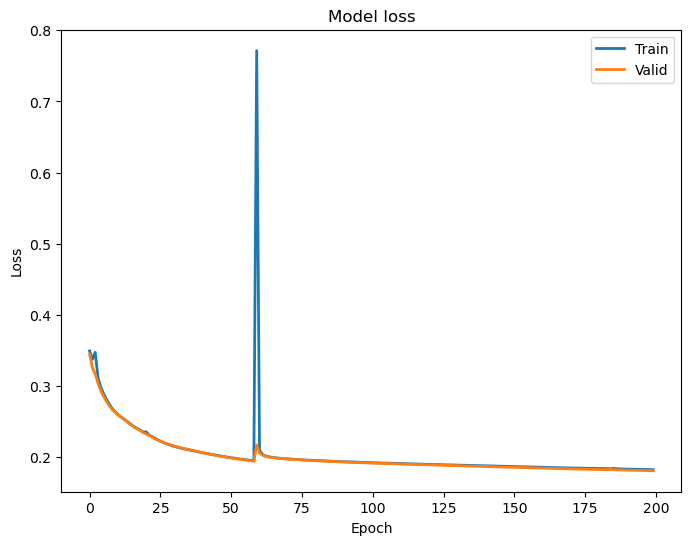

In [49]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Sanity check
Doing a sanity check by validating the reconstruction error 
on the train data. Here we will reconstruct the entire train 
data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should
be smaller than 1.

**Caution**: do not use this result for model evaluation. It may
result into overfitting issues.

74/74 [==============================] - 1s 12ms/step


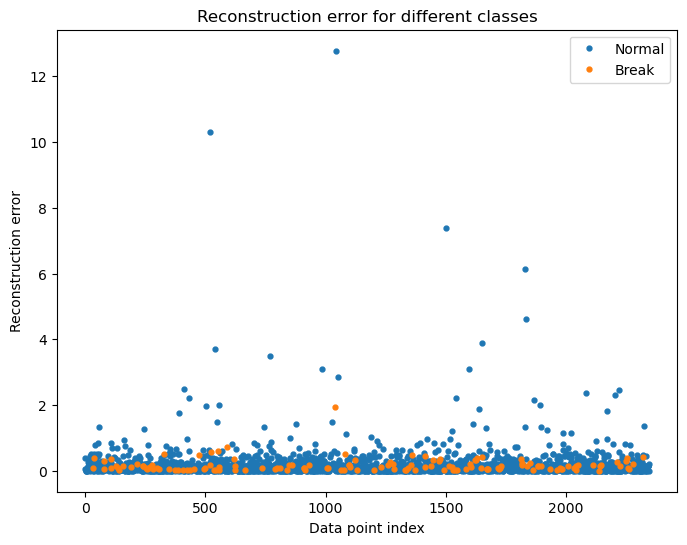

In [50]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Predictions using the Autoencoder

19/19 [==============================] - 0s 12ms/step


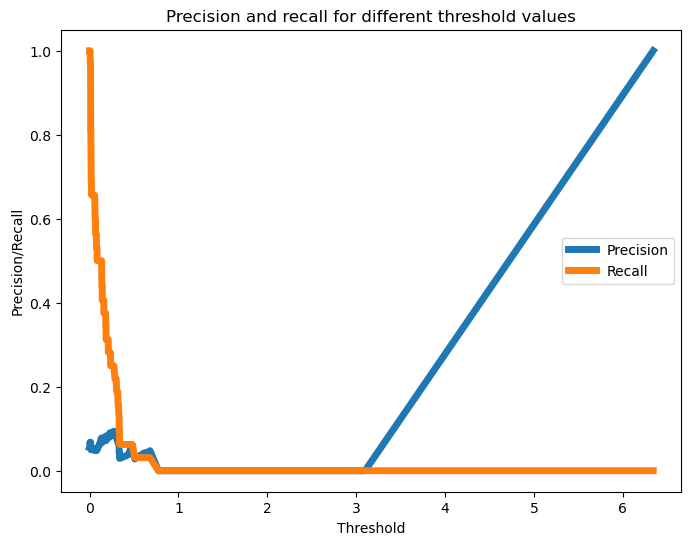

In [51]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

23/23 [==============================] - 0s 12ms/step


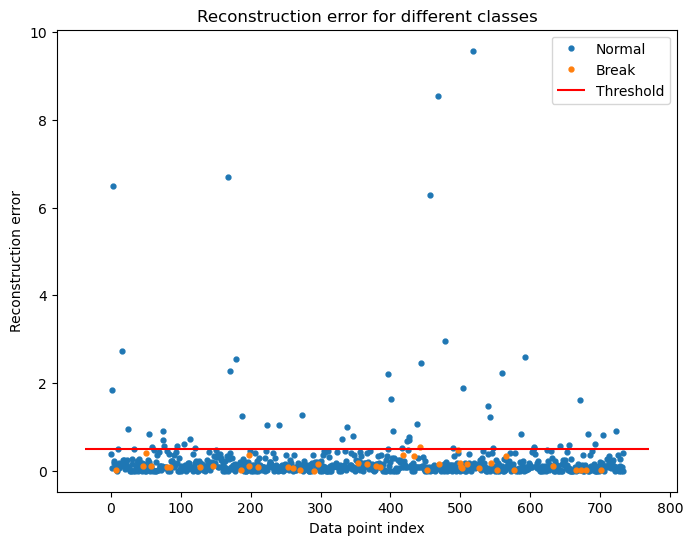

In [52]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

74/74 [==============================] - 1s 12ms/step


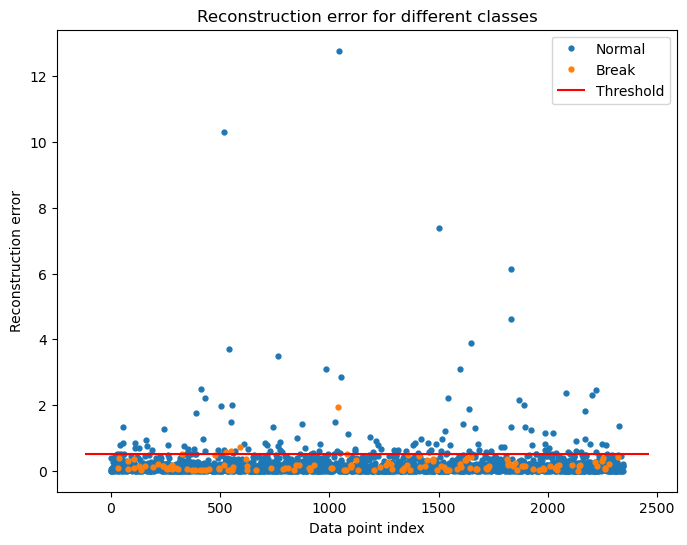

In [53]:
train_x_predictions = lstm_autoencoder.predict(X_train)
mse = np.mean(np.power(flatten(X_train) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

threshold_fixed = 0.5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [54]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

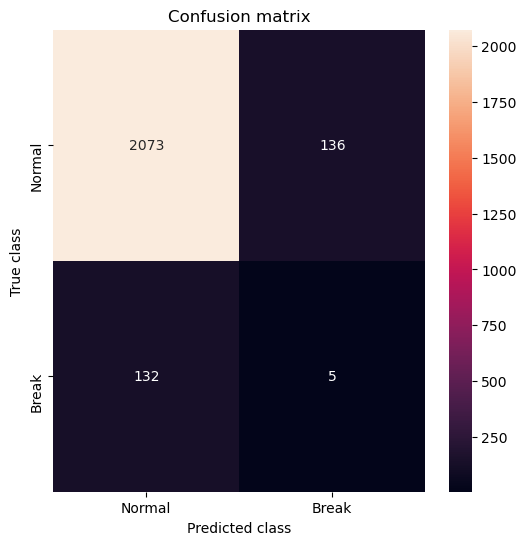

In [55]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [56]:
target_names = ['Normal', 'Break']

print(classification_report(error_df.True_class, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94      2209
       Break       0.04      0.04      0.04       137

    accuracy                           0.89      2346
   macro avg       0.49      0.49      0.49      2346
weighted avg       0.89      0.89      0.89      2346



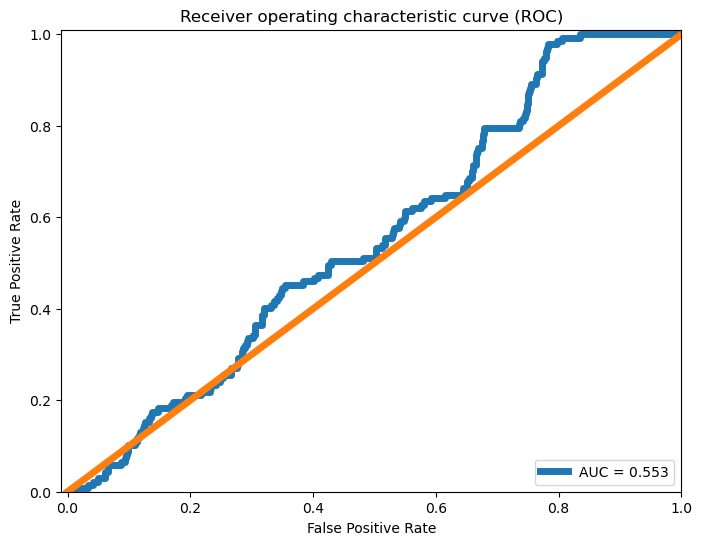

In [57]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()